In [1]:
import tensorflow as tf
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt
import IPython.display as display
import numpy as np
import glob
import random
import tensorflow_hub as hub
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense

BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224
CLASS_NAMES = ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']

In [2]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
!pip install tensorflow_hub

In [4]:
tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
tf.test.is_built_with_cuda()

True

In [6]:
train_ds =  tf.data.Dataset.list_files("/kaggle/input/okdir-tarp/Training Images/*.jpg")
val_ds = tf.data.Dataset.list_files("/kaggle/input/okdir-tarp/Testing Images/*.jpg")

In [7]:
#train_ds.shape()

In [8]:
def get_label(name):
    name = tf.strings.split(name, sep="/")[-1]
    name = tf.strings.split(name, sep="-")[-1]
    name=tf.strings.split(name, sep=".jpg")[0]
    img_label = tf.strings.bytes_split(name)
    l = [0, 0, 0, 0, 0, 0, 0, 0]
    for i in img_label:
        if i == 'N':
           l[0] = 1
        elif i == 'D':
          l[1] = 1
        elif i == 'G':
          l[2] = 1
        elif i == 'C':
          l[3] = 1
        elif i == 'A':
          l[4] = 1
        elif i == 'H':
          l[5] = 1
        elif i == 'M':
          l[6] = 1
        elif i =='O':
          l[7] = 1
    return l
def get_name(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-1]

def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return img

def process_path(file_path):
    name = get_name(file_path)
    label = get_label(name)
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [9]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)
print(train)
print(val)

<ParallelMapDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.float32, name=None), TensorSpec(shape=(8,), dtype=tf.int32, name=None))>
<ParallelMapDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.float32, name=None), TensorSpec(shape=(8,), dtype=tf.int32, name=None))>


(512, 512, 3)
label:  O [0 0 0 0 0 0 0 1]
(512, 512, 3)
label:  N [1 0 0 0 0 0 0 0]
(512, 512, 3)
label:  M [0 0 0 0 0 0 1 0]
(512, 512, 3)
label:  N [1 0 0 0 0 0 0 0]
(512, 512, 3)
label:  G [0 0 1 0 0 0 0 0]
(512, 512, 3)
label:  N [1 0 0 0 0 0 0 0]


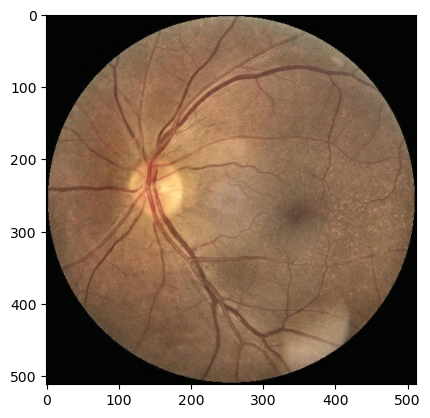

In [10]:
for image, label in val.take(6):
  print(image.shape)
  plt.imshow(image.numpy())
  print('label: ', CLASS_NAMES[np.nonzero(label.numpy()==1)[0][0]], label.numpy())

In [11]:
def randomly_augment(image,label):
#   image = tf.image.random_flip_left_right(image)
  #image = tf.image.central_crop(image, central_fraction=0.9)
#   image = tf.image.resize_with_pad(image, IMG_HEIGHT, IMG_WIDTH, method='bilinear', antialias=False)
#   image=tf.image.rgb_to_grayscale(image)
  
  image= tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH], method='bilinear', preserve_aspect_ratio=True)
#   image=tf.image.per_image_standardization(image)
#   image=tf.image.per_image_standardization(image)
#   image=image/ 255.0
  return image, label

def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
  ds = ds.shuffle(buffer_size=shuffle_buffer_size, reshuffle_each_iteration=False)
  ds = ds.map(randomly_augment, num_parallel_calls=AUTOTUNE)
  ds = ds.repeat()
  ds = ds.batch(BATCH_SIZE, drop_remainder=True)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

def prepare_for_testing(ds, cache=True):
  #caches the dataset in memory or on disk, which can speed up subsequent reads.
  ds = ds.cache()
  ds = ds.map(randomly_augment, num_parallel_calls=AUTOTUNE)
  #batches the dataset into batches of size 32, dropping the last batch if it is smaller than 32.
  ds = ds.batch(BATCH_SIZE, drop_remainder=True) 
  #repeats the dataset indefinitely, so that it can be used for multiple epochs during training or evaluation.
#   ds = ds.repeat()

  return ds
final_train_ds = prepare_for_training(train,cache=True)
final_val_ds = prepare_for_testing(val,cache=True)

In [12]:
for image, label in final_val_ds.take(6):
  print(image.shape)


(32, 224, 224, 3)
(32, 224, 224, 3)
(32, 224, 224, 3)
(32, 224, 224, 3)
(32, 224, 224, 3)
(32, 224, 224, 3)


In [13]:
IMAGE_SIZE=[IMG_HEIGHT,IMG_WIDTH]

In [14]:
import random
def get_model():
    vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)
    for layer in vgg.layers:
        layer.trainable = False
    x1= Conv2D(32, kernel_size=(2, 2), activation='relu', padding='valid', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)) (vgg.output)
    x2= MaxPooling2D(pool_size=(2, 2),strides=(2,2),padding="valid")(x1)
    x3= Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same')(x2)
    x4= MaxPooling2D(pool_size=(2, 2),padding="valid")(x3)
#     x5= tf.keras.layers.Dropout(0.5,)(x4)
    x5= Flatten()(x4)
#     x7= Dense(units=128, activation='relu')(x6)
    
    x6= Dense(units=64, activation='relu')(x5)
    x7= tf.keras.layers.Dropout(0.5,)(x6)
    prediction= Dense(units=8, activation='sigmoid')(x7)
    
    #     model = tf.keras.Sequential()
    
#     model.add(Conv2D(32, kernel_size=(2, 2), activation='relu', padding='valid', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)))
#     model.add(MaxPooling2D(pool_size=(2, 2),strides=(2,2),padding="valid"))
#     model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'))
#     model.add(tf.keras.layers.AveragePooling2D(pool_size=(2, 2),padding="valid"))
#     model.add(tf.keras.layers.Dropout(0.5,))
#     model.add(Flatten())
#     model.add(Dense(units=128, activation='relu'))
#     model.add(tf.keras.layers.Dropout(0.5,))
#     model.add(Dense(units=64, activation='relu'))
#     model.add(Dense(units=8, activation='sigmoid'))
    
    model = Model(inputs=vgg.input, outputs=prediction)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
    return model
   


In [15]:
model=get_model()
model.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [16]:
from keras.callbacks import ModelCheckpoint

# Define the file name for saving the best weights
best_weights_filepath = "/kaggle/working/weights_best.h5"

# Define the ModelCheckpoint callback for saving the best weights
best_checkpoint = ModelCheckpoint(best_weights_filepath,
                                  monitor='val_accuracy',
                                  verbose=1,
                                  save_best_only=True,
                                  mode='max')

best_checkpoint_loss = ModelCheckpoint("/kaggle/working/weights_best_loss.h5",
                                  monitor='val_loss',
                                  verbose=1,
                                  save_best_only=True,
                                  mode='min')

# Define the file name for saving the last weights
last_weights_filepath = "/kaggle/working/weights_last.h5"

# Define the ModelCheckpoint callback for saving the last weights
last_checkpoint = ModelCheckpoint(last_weights_filepath,
                                  save_weights_only=True,
                                  save_freq=(685*32)//BATCH_SIZE)

tb_callback=tf.keras.callbacks.TensorBoard(log_dir="/kaggle/working/logs_CNN/Original/",histogram_freq=1)

In [17]:
# history=model.fit(final_train_ds.repeat(),
#                     #batch_size=32,
#                     epochs=50,
#                     steps_per_epoch = 189, #train_elements/batch_size
#                     validation_data=final_val_ds.repeat(),
#                     validation_steps = 31,
#                     callbacks=[best_checkpoint_loss],
# #                     use_multiprocessing=True,
#                     #class_weight=class_weight
#                     )

history=model.fit(final_train_ds.repeat(),
                    #batch_size=32,
                    epochs=50,
                    steps_per_epoch = 697, #train_elements/batch_size
                    validation_data=final_val_ds.repeat(),
                    validation_steps = 31,
                    callbacks=[best_checkpoint],
#                     use_multiprocessing=True,
                    #class_weight=class_weight
                    )


Epoch 1/50
697/697 [==============================] - ETA: 0s - loss: 0.3075 - accuracy: 0.4093 - precision: 0.7077 - recall: 0.2278
Epoch 1: val_accuracy improved from -inf to 0.54435, saving model to /kaggle/working/weights_best.h5
697/697 [==============================] - 138s 176ms/step - loss: 0.3075 - accuracy: 0.4093 - precision: 0.7077 - recall: 0.2278 - val_loss: 0.2406 - val_accuracy: 0.5444 - val_precision: 0.8740 - val_recall: 0.3231
Epoch 2/50
697/697 [==============================] - ETA: 0s - loss: 0.2447 - accuracy: 0.5434 - precision: 0.8327 - recall: 0.3508
Epoch 2: val_accuracy improved from 0.54435 to 0.59879, saving model to /kaggle/working/weights_best.h5
697/697 [==============================] - 95s 137ms/step - loss: 0.2447 - accuracy: 0.5434 - precision: 0.8327 - recall: 0.3508 - val_loss: 0.2135 - val_accuracy: 0.5988 - val_precision: 0.8231 - val_recall: 0.4381
Epoch 3/50
697/697 [==============================] - ETA: 0s - loss: 0.2188 - accuracy: 0.6024 

In [18]:
model.save("/kaggle/working/weights_last.h5")

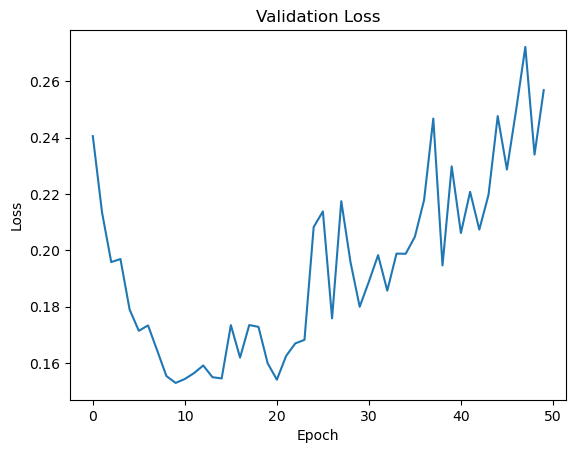

In [19]:
# Plot the validation loss
val_loss = history.history['val_loss']
plt.plot(val_loss)
plt.title('Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [20]:
import pickle
with open('history.pkl', 'wb') as file:
    pickle.dump(history.history, file)
df = pd.DataFrame(history.history)
df.to_csv('history.csv', index=False)
np.save('history.npy', history.history)

In [21]:
from keras.models import load_model
loaded_model =load_model("/kaggle/working/weights_best_loss.h5")
loaded_model.summary()

OSError: No file or directory found at /kaggle/working/weights_best_loss.h5

In [23]:
[loss,accuracy,precision,recall]=loaded_model.evaluate(final_val_ds,steps=31)
print("Accuracy: ",accuracy*100)

NameError: name 'loaded_model' is not defined